In [1]:
import comet_ml

import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from fastai.tabular.all import *

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, brier_score_loss, roc_auc_score, confusion_matrix, classification_report, roc_curve, PrecisionRecallDisplay 
from sklearn.calibration import CalibrationDisplay

In [2]:
EXP_DESCRIPTION = 'CE-ES'

In [3]:
PATH_REL_PREFIX = '..'
load_dotenv(f'{PATH_REL_PREFIX}/.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
exp = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name='ift6758',
    workspace='meriembchaaben',
)
exp.set_name(f'Question6/YourBestShot-fastai-{EXP_DESCRIPTION}')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/meriembchaaben/ift6758/b037038651174cecb547c2b7d4dd55ea



In [4]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

def compute_cumulative_goal_rate_per_percentile(probs, y):
        percentiles = []
        rates = []
        cum_rate = 0

        for i in range(0, 101):
            percentile = np.percentile(probs, i)
            goals = 0
            no_goals = 0
            for idx, p in enumerate(probs):
                if p<=percentile:
                    if y[idx]==1:
                        goals+=1
                    else:
                        no_goals+=1
            cum_rate += goals / (goals + no_goals)
            percentiles.append(percentile)
            rates.append(cum_rate)
        return percentiles, rates


def plot_metrics(learn, y_val_pred, val_y_pred_proba, y_val):
    params = {'classifier': 'FastAI NN'}
    random_clf = DummyClassifier(strategy="uniform").fit(X_train, y_train)
    random_probs = random_clf.predict_proba(X_val)[:, 1]

    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_brier = brier_score_loss(y_val, y_val_pred)
    
    #F1 Score (Macro)
    print(f'F1 Score (Macro) Validation: {val_f1}')
    exp.log_metric('F1 Score (Macro) Validation', val_f1)

    #Brier Score 
    print(f'Brier Score Validation: {val_brier}')
    exp.log_metric('Brier Score Validation', val_brier)

    # Log Model Architecture
    exp.log_text(learn.model)

    # Confusion Matrix
    print(confusion_matrix(y_val, y_val_pred))
    exp.log_confusion_matrix(y_val, y_val_pred)

    # Classification Report
    print(classification_report(y_val, y_val_pred))
    exp.log_text(classification_report(y_val, y_val_pred))

    ### PR Curve -- AUC metric ###
    display = PrecisionRecallDisplay.from_predictions(y_val, val_y_pred_proba)
    display.ax_.set_title("2-class Precision-Recall curve")
    exp.log_figure('PR AUC Curve', display.figure_)

    ### ROC curve - AUC metric ###
    pipe_roc_auc = roc_auc_score(y_val, y_val_pred)
    random_auc = roc_auc_score(y_val, random_probs)
    print('Our Model: ROC AUC=%.3f' % (pipe_roc_auc))
    print('Random: ROC AUC=%.3f' % (random_auc))
    exp.log_metric('ROC AUC', pipe_roc_auc)
    xgb_fpr, xgb_tpr, _ = roc_curve(y_val, val_y_pred_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(xgb_fpr, xgb_tpr, marker='.', label=f'{params["classifier"]}')
    plt.plot([0, 1], [0, 1], linestyle='--', marker='.', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    exp.log_figure('ROC AUC Curve', plt)
    # plt.savefig('../figures/roc.png')
    plt.show()


    # The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile,
    # i.e. if a value is the 70th percentile, it is above 70% of the data. 
    ### goal_rate = F(shot probability model percentile) ###
    percentiles1, rates1 = compute_goal_rate_per_percentile(val_y_pred_proba, y_val)
    percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val)
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_1.png')
    exp.log_figure('Goal Rate vs Predicted Percentile', plt)
    plt.show()


    # c. The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.
    percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(val_y_pred_proba, y_val)
    percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val)
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_2.png')
    exp.log_figure('Cumulative Goal Rate vs Predicted Percentile', plt)
    plt.show()

    # # d. The reliability diagram (calibration curve).
    fig, ax = plt.subplots(figsize=(6, 6))
    
    disp1 = CalibrationDisplay.from_predictions(y_val, val_y_pred_proba, label=f'{params["classifier"]}', ax=ax)
    disp4 = CalibrationDisplay.from_estimator(random_clf, X_val, y_val, label='Random', ax=ax)
    # plt.savefig('../figures/calibration_diagram.png')
    exp.log_figure('Reliability Diagram', plt)
    plt.show()

In [5]:
path = '../data/M2Data'
# df = pd.read_csv(f'{path}/trainingSet.csv')

# df['strength'] = df['strength2']

# df['rebound'] = df.rebound.astype(int)
# df['Goal'] = df['Goal'].astype(int)
# df['EmptyNet'] = df['EmptyNet'].astype(int)

# df.fillna({'changeInAngleShot': 0}, inplace=True)

# df = df.drop(labels=[
#     'totalPlayTime', 'gameID', 'eventType',
#     'periodTime',
#     'lastEventPeriodTime',
#     'strength2',
#     'lastEventAngle',
#     'lastEventGameSeconds',
#     'emptyNet',
#     'lastEventPeriod',
#     'xCoord', 'yCoord',
#     'lastEventXCoord', 'lastEventYCoord',
#     'index',
# ], axis=1, errors='ignore')

# df.replace({
#     'Goal':
#         {
#             0: 'Shot',
#             1: 'Goal',
#         }
#     }, inplace=True)

# df.to_csv(f'{path}/traningSetFastAI.csv', index=False)


df = pd.read_csv(f'{path}/traningSetFastAI.csv')

In [6]:
# Train / Valid Split
season_split = 2018
train_ix, valid_ix = df[df.season < season_split].index, df[df.season >= season_split].index

X, y = df.drop(labels='Goal', axis=1), df['Goal']
train_df, valid_df = df.iloc[train_ix], df.iloc[valid_ix]

X_train, X_val, y_train, y_val = X.iloc[train_ix], X.iloc[valid_ix], y.iloc[train_ix], y.iloc[valid_ix]

# exp.log_dataset_info(name='trainingSet.csv', version='2021-11-17', path=f'{PATH_REL_PREFIX}/data/M2Data/trainingSet.csv')

# for dataset in [X_train, X_val, y_train, y_val]:
#     exp.log_dataset_hash(dataset)

X_train.shape, X_train.columns, y_train.shape, y_train.name

((230628, 24),
 Index(['period', 'periodType', 'teamOfShooter', 'homeOrAway', 'shooter',
        'goalie', 'shotType', 'strength', 'season', 'rinkSide', 'gameType',
        'lastEventType', 'EmptyNet', 'distanceFromNet', 'angle', 'gameSeconds',
        'timeFromLastEvent', 'distanceFromLastEvent', 'rebound',
        'changeInAngleShot', 'speed', 'timeSincePowerPlayStarted',
        'numFriendlyNonGoalieSkaters', 'numOpposingNonGoalieSkaters'],
       dtype='object'),
 (230628,),
 'Goal')

In [7]:
cat_names = list(set(df.dtypes[df.dtypes == object].keys()) - set(['Goal'])) + [ 'period', 'season', 'EmptyNet', 'rebound']
cont_names = [col for col in df.columns if col not in cat_names and col != 'Goal']

In [8]:
cat_names

['rinkSide',
 'gameType',
 'lastEventType',
 'periodType',
 'shotType',
 'teamOfShooter',
 'strength',
 'goalie',
 'homeOrAway',
 'shooter',
 'period',
 'season',
 'EmptyNet',
 'rebound']

In [9]:
cont_names

['distanceFromNet',
 'angle',
 'gameSeconds',
 'timeFromLastEvent',
 'distanceFromLastEvent',
 'changeInAngleShot',
 'speed',
 'timeSincePowerPlayStarted',
 'numFriendlyNonGoalieSkaters',
 'numOpposingNonGoalieSkaters']

In [10]:
target = "Goal"

In [11]:
dls = TabularDataLoaders.from_df(train_df, y_names=target,
    cat_names = cat_names,
    cont_names = cont_names,
    procs = [Categorify, FillMissing, Normalize])


In [12]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
print(type(splits), type(splits[0]), type(splits[1]))

<class 'tuple'> <class 'fastcore.foundation.L'> <class 'fastcore.foundation.L'>


In [13]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names=target,
                   splits=splits)

dls = to.dataloaders(bs=64, shuffle=True)


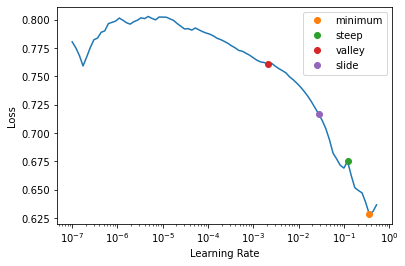

In [14]:
learn = tabular_learner(
    dls, metrics=[F1Score(average='macro'), BalancedAccuracy(), BrierScore(pos_label=0)],
    # loss_func=FocalLossFlat(gamma=2),
    # loss_func=BCEWithLogitsLossFlat(),
    cbs=[
            EarlyStoppingCallback(monitor='f1_score', min_delta=0.0001, patience=5),
            SaveModelCallback(fname='best', monitor='f1_score'),
            SaveModelCallback(fname='end', at_end=True)
        ]
    )
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [15]:
with exp.train():
    # learn.fit_one_cycle(5, lr_min)
    learn.fit_sgdr(5,2)


exp.log_model("FastAI Best Model", "models/best.pth")
exp.log_model("FastAI Final Model", "models/end.pth")


epoch,train_loss,valid_loss,f1_score,balanced_accuracy_score,brier_score_loss,time
0,0.261915,0.257376,0.534050,0.529680,0.915252,00:21
1,0.248071,0.255667,0.530965,0.527983,0.914949,00:21
2,0.256307,0.257795,0.535593,0.530487,0.914732,00:21
3,0.256006,0.259356,0.536984,0.531233,0.914298,00:21
4,0.237663,0.259168,0.538020,0.531805,0.914146,00:21
5,0.239424,0.261856,0.545644,0.536170,0.913734,00:21
6,0.256852,0.262212,0.542376,0.534274,0.913864,00:21
7,0.257102,0.260884,0.545601,0.536137,0.914472,00:21
8,0.264665,0.266013,0.549414,0.538408,0.913431,00:21
9,0.235368,0.266607,0.550763,0.539223,0.913322,00:22


Better model found at epoch 0 with f1_score value: 0.5340502428918339.
Better model found at epoch 0 with valid_loss value: 0.25737595558166504.
Better model found at epoch 1 with valid_loss value: 0.2556673586368561.
Better model found at epoch 2 with f1_score value: 0.5355933204649332.
Better model found at epoch 3 with f1_score value: 0.5369843572548159.
Better model found at epoch 4 with f1_score value: 0.5380202399717955.
Better model found at epoch 5 with f1_score value: 0.5456439807627702.
Better model found at epoch 8 with f1_score value: 0.5494136082409579.
Better model found at epoch 9 with f1_score value: 0.550762612243237.
Better model found at epoch 11 with f1_score value: 0.5547402552508722.
Better model found at epoch 12 with f1_score value: 0.558603793884283.
Better model found at epoch 13 with f1_score value: 0.5628684874385363.
No improvement since epoch 13: early stopping


{'web': 'https://www.comet.ml/api/asset/download?assetId=0248c6d833734e068989ea4b233768cd&experimentKey=b037038651174cecb547c2b7d4dd55ea',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=0248c6d833734e068989ea4b233768cd&experimentKey=b037038651174cecb547c2b7d4dd55ea',
 'assetId': '0248c6d833734e068989ea4b233768cd'}

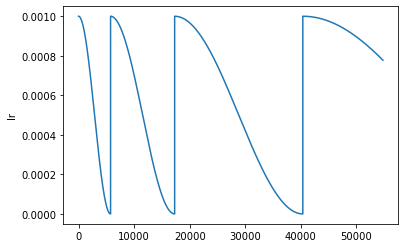

In [16]:
learn.recorder.plot_sched()

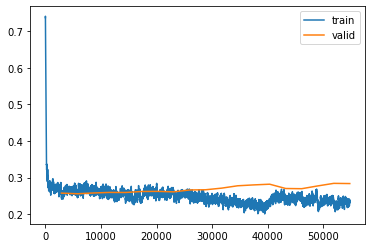

In [17]:
learn.recorder.plot_loss()

In [18]:
test_df = valid_df.copy()
test_df.drop([target], axis=1, inplace=True)
test_df.fillna({'angle': 0}, inplace=True)
dl = learn.dls.test_dl(test_df, ignore_exceptions=True)
y_pred = learn.get_preds(dl=dl)

y_val_pred = np.argmin(y_pred[0], axis=1)
val_y_pred_proba = np.array(y_pred[0][:,0])
y_val_binary = y_val.replace({'Shot': 0, 'Goal': 1}).to_list()

In [19]:
with open(f'./predictions/fastai-{EXP_DESCRIPTION}.pkl', 'wb') as f:
    pickle.dump(
        { 
            'model': 'fastai-{EXP_DESCRIPTION}.pkl',
            'validation_set_predicted_probs': val_y_pred_proba,
            'validation_set_predicted_labels': y_val_pred,
            'validation_set_actual_labels': y_val_binary
        },
        f
    )

In [20]:
# exp.log_artifact('./predictions/fastai-{EXP_DESCRIPTION}.pkl')

COMET ERROR: Failed to log asset data as JSON


F1 Score (Macro) Validation: 0.5588774856198988
Brier Score Validation: 0.1029970923730709
[[71324  1389]
 [ 6900   865]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     72713
           1       0.38      0.11      0.17      7765

    accuracy                           0.90     80478
   macro avg       0.65      0.55      0.56     80478
weighted avg       0.86      0.90      0.87     80478

Our Model: ROC AUC=0.546
Random: ROC AUC=0.500


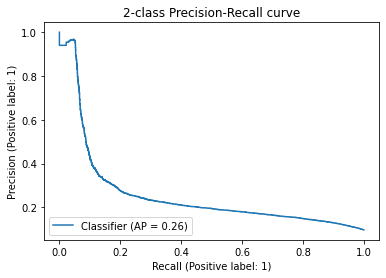

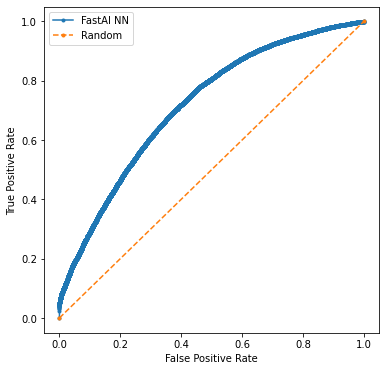

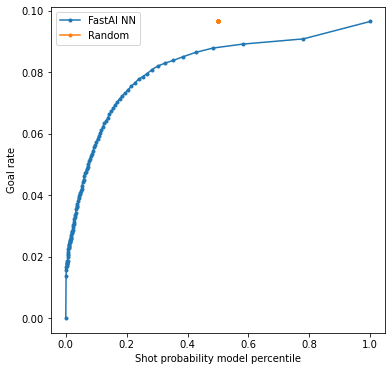

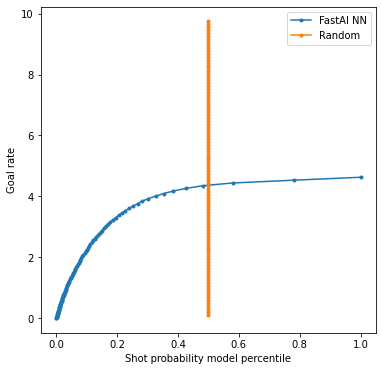

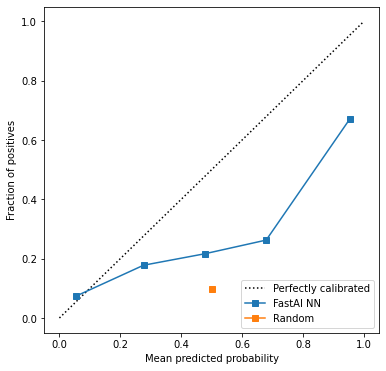

In [21]:
plot_metrics(learn, y_val_pred, val_y_pred_proba, y_val_binary)

In [22]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/meriembchaaben/ift6758/b037038651174cecb547c2b7d4dd55ea
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Brier Score Validation      : 0.1029970923730709
COMET INFO:     F1 Score (Macro) Validation : 0.5588774856198988
COMET INFO:     ROC AUC                     : 0.5461473983457921
COMET INFO:     loss [18]                   : (0.434376060962677, 13.235371589660645)
COMET INFO:     train_loss [10952]          : (0.07358131557703018, 0.7896100282669067)
COMET INFO:   Others:
COMET INFO:     Name : Question6/YourBestShot-fastai-CE-ES
COMET INFO:   Parameters:
COMET INFO:     constant     : 1
COMET INFO:     random_state : 1
COMET INFO:     strategy     : uniform
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO